In [8]:
import pandas as pd
from src.config import get_interim_dir
import seaborn as sns
from random import choices
from pyod.models.mcd import MCD
from pyod.models.ecod import ECOD
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [9]:
all_data = {}
for t in ["T1", "T2", "T3"]:
    all_data[t] = pd.read_pickle(get_interim_dir() + "agg_pca_analysis_{}.pkl".format(t))

In [79]:
ecod_scores = {}
ecod_output = {}
mcd_scores = {}
mcd_output = {}
Ys = {}
for i in range(1):
    Ys[i] = {}
    ecod_output[i] = {}
    ecod_scores[i] = {}
    mcd_scores[i] = {}
    mcd_output[i] = {}
    for t in tqdm(["T1", "T2", "T3"]):
        X = all_data[t]["X"]
        Y=[]
        def generate_bootstrap_samples(x):
            repair_outcomes = x.index.to_list()
            outcome_frequencies = x.values
            boostrapped_outcomes = pd.Series(choices(repair_outcomes, outcome_frequencies, k=1000)).value_counts()
            boostrapped_outcomes = boostrapped_outcomes/boostrapped_outcomes.sum()
            # Y.loc[x.name, boostrapped_outcomes.index] = boostrapped_outcomes.values
            Y.append(pd.DataFrame({
                "Gene": x.name,
                "Frequency" : boostrapped_outcomes.values,
                "Outcome": boostrapped_outcomes.index.to_list(),
                }))

        X.apply(generate_bootstrap_samples, axis=1)
        Y = pd.concat(Y)
        Y = Y.pivot(index=["Gene"], columns=["Outcome"], values="Frequency").fillna(0)
        Y.loc[:, (Y != 0).any(axis=0)]
        
        Ys[i][t] = Y

        ecod_output[i][t] = ECOD().fit(X)
        ecod_scores[i][t] = pd.Series(ecod_output[i][t].decision_scores_, index=Y.index)
        ecod_scores[i][t] = ecod_scores[i][t].sort_values(ascending=False)

        mcd_output[i][t] = MCD(random_state=0).fit(Y)
        mcd_scores[i][t] = pd.Series(mcd_output[i][t].decision_scores_, index=Y.index)
        mcd_scores[i][t] = mcd_scores[i][t].sort_values(ascending=False)


 33%|███▎      | 1/3 [00:44<01:28, 44.01s/it]/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-1241.068520746645163 > -1241.129134067294444). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
 67%|██████▋   | 2/3 [01:21<00:40, 40.20s/it]/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-1181.170786878895342 > -1181.452070691222616). You may want to try with a higher value of support_fraction (current value: 0.505).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previo

In [111]:
ecod_scores_df = pd.DataFrame(ecod_scores[0])
mcd_scores_df = pd.DataFrame(mcd_scores[0])

In [112]:
ecod_scores_df[["T1_rank", "T2_rank", "T3_rank"]] = ecod_scores_df[["T1", "T2", "T3"]].rank(ascending=False)
mcd_scores_df[["T1_rank", "T2_rank", "T3_rank"]] = mcd_scores_df[["T1", "T2", "T3"]].rank(ascending=False)

In [113]:
ecod_scores_df["total_score"] = ecod_scores_df[["T1_rank", "T2_rank", "T3_rank"]].apply(lambda x: sum(x.sort_values()[:2]), axis=1)
mcd_scores_df["total_score"] = mcd_scores_df[["T1_rank", "T2_rank", "T3_rank"]].apply(lambda x: sum(x.sort_values()[:2]), axis=1)

In [136]:
ecod_scores_df.sort_values("total_score").index.get_loc("Rrm1")

80

In [115]:
ecod_scores_df.sort_values("total_score").head()

,T1,T2,T3,T1_rank,T2_rank,T3_rank,total_score
Gene,,,,,,,
Polq,250.275544,272.116195,229.969813,4.0,2.0,54.0,6.0
Zpld1,248.911931,172.811784,242.199097,7.0,1022.0,21.0,28.0
Caap1,261.958593,234.886285,236.403358,1.0,31.0,32.0,32.0
Tomm22,NaN,237.760929,244.687499,NaN,24.0,14.0,38.0
Rsl1d1,232.368849,238.497610,221.435212,39.0,20.0,102.0,59.0


In [225]:
mcd_scores_df.sort_values("total_score").head(20)

,T1,T2,T3,T1_rank,T2_rank,T3_rank,total_score
Gene,,,,,,,
Mars1,NaN,25636.848289,2281.844604,NaN,122.0,20.0,142.0
Ptma,956.846211,311.419657,668.982239,41.0,1463.0,134.0,175.0
Serpinb6d,180.543099,25489.242739,1179.551964,1495.0,128.0,47.0,175.0
Vmn2r63,229.243704,100971.033192,629.587353,870.0,41.0,145.0,186.0
Ptpn5,843.170016,79.182383,1005.433672,96.0,13299.0,90.0,186.0
Cd40lg,797.867535,116.434989,1007.818128,108.0,6660.0,88.0,196.0
Crkl,214.667609,25419.240483,1070.845549,1017.0,139.0,57.0,196.0
Tmed2,535.901956,100952.308295,101.015367,151.0,46.0,7813.0,197.0
Masp1,842.177323,66.476193,880.571610,97.0,16038.0,109.0,206.0


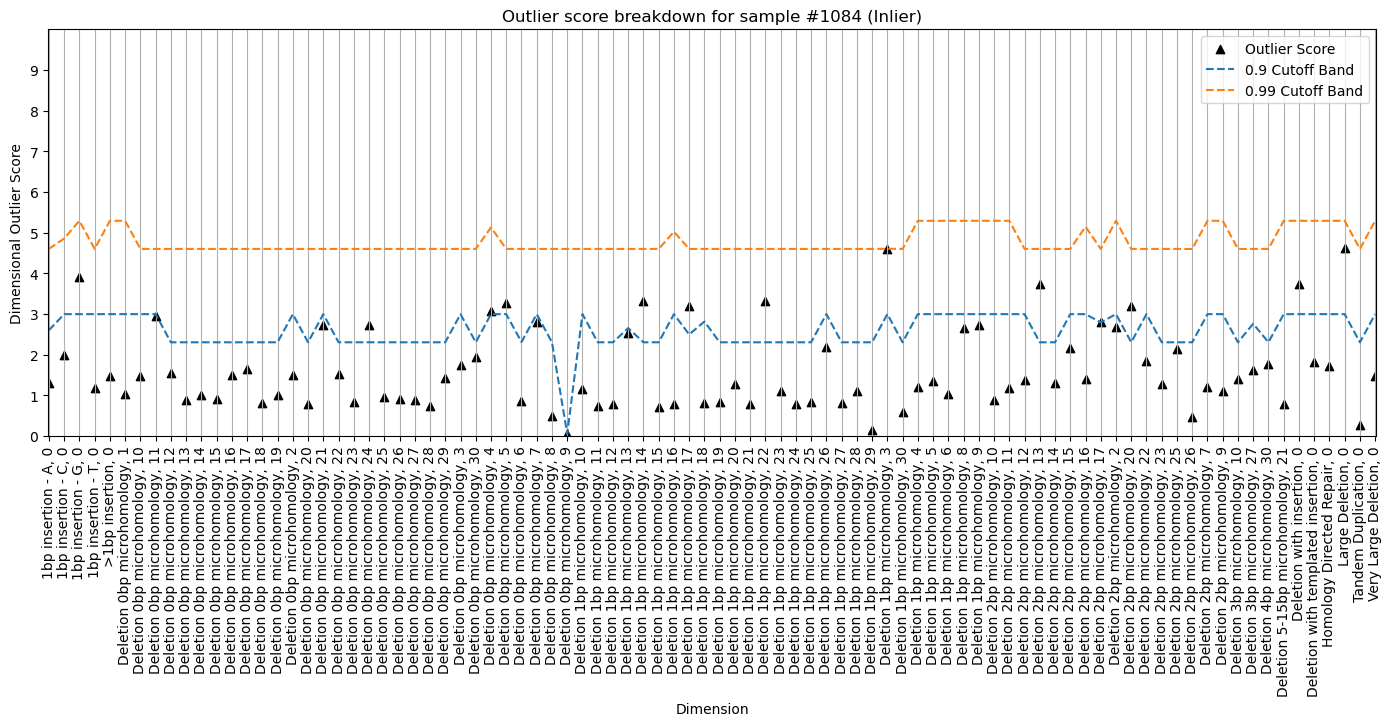

In [233]:
from src.visualization.ecod import explain_outlier
import matplotlib.pyplot as plt

run = 0
t = "T3"
g = "Anxa9"

plt.figure(figsize=(15,5))
explain_outlier(ecod_output[run][t], Ys[run][t].index.get_loc(g), feature_names=Ys[run][t].columns.to_list())

['Thbs1', 'Mars1', 'Ptma', 'Serpinb6d', 'Vmn2r63', 'Ptpn5']


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


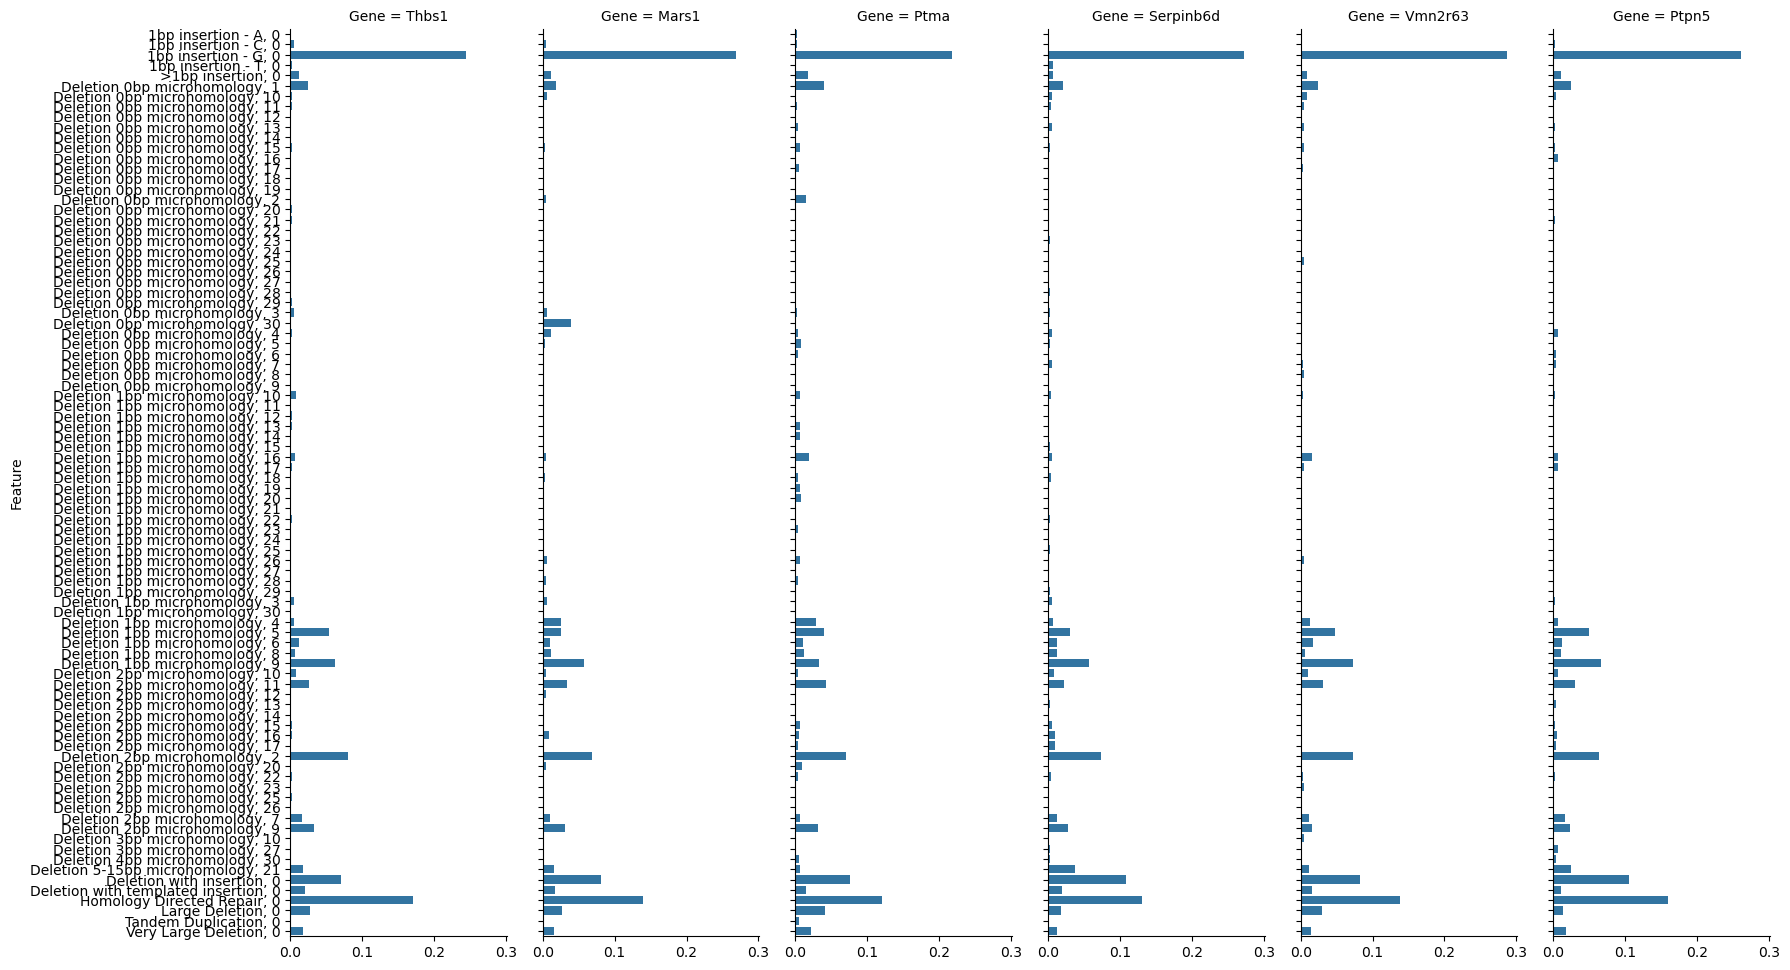

In [214]:
examples = Y.index.to_series().sample(5)
examples = mcd_scores_df.dropna().sort_values("total_score").tail(1).index.to_list() + mcd_scores_df.sort_values("total_score").head().index.to_list()
ax = Y.loc[examples].fillna(0)
print(examples)

ax = ax.reset_index().melt(id_vars="Gene", var_name="Feature")
ax["logvalue"] = np.log10(ax["value"])
g = sns.FacetGrid(data=ax, col="Gene", height=10, aspect=.3, col_wrap=6)
g.map_dataframe(sns.barplot, y="Feature", x="value")
g.set(xlabel=None)


['Thbs1', 'Mars1', 'Ptma', 'Serpinb6d', 'Vmn2r63', 'Ptpn5']


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='value', ylabel='Feature'>

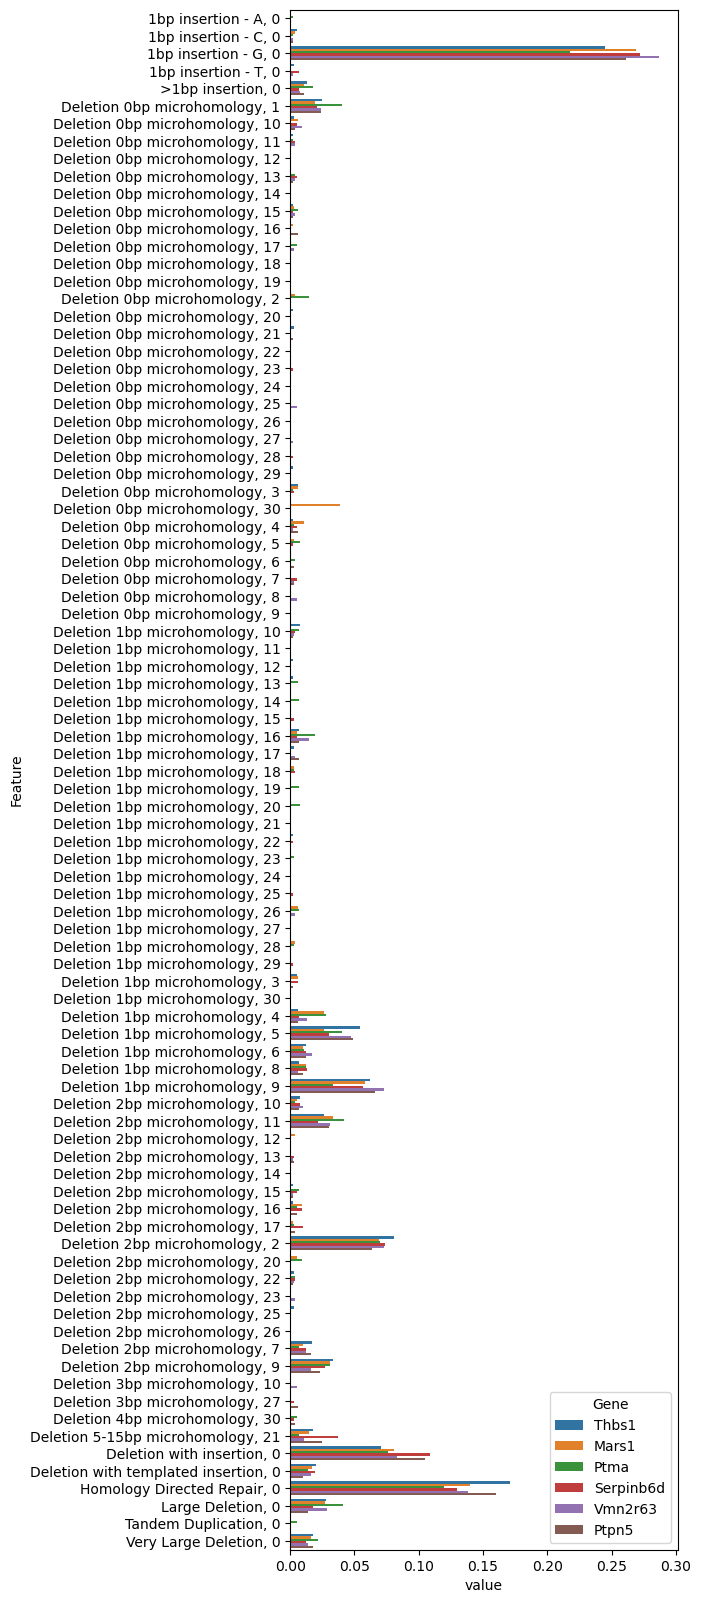

In [221]:
examples = Y.index.to_series().sample(5)
examples = mcd_scores_df.dropna().sort_values("total_score").tail(1).index.to_list() + mcd_scores_df.sort_values("total_score").head().index.to_list()
ax = Y.loc[examples].fillna(0)
print(examples)

plt.figure(figsize=(5,20))

ax = ax.reset_index().melt(id_vars="Gene", var_name="Feature")
ax["logvalue"] = -np.log10(ax["value"])
sns.barplot(data=ax, y="Feature", x="value", hue="Gene")


Some interesting genes that we found

Rrm1 - 
Desciption: This gene encodes the large and catalytic subunit of ribonucleotide reductase, an enzyme essential for the conversion of ribonucleotides into deoxyribonucleotides. A pool of available deoxyribonucleotides is important for DNA replication during S phase of the cell cycle as well as multiple DNA repair processes. Alternative splicing results in multiple transcript variants.
Effect - Seems to heavily influence the number of insertions. 

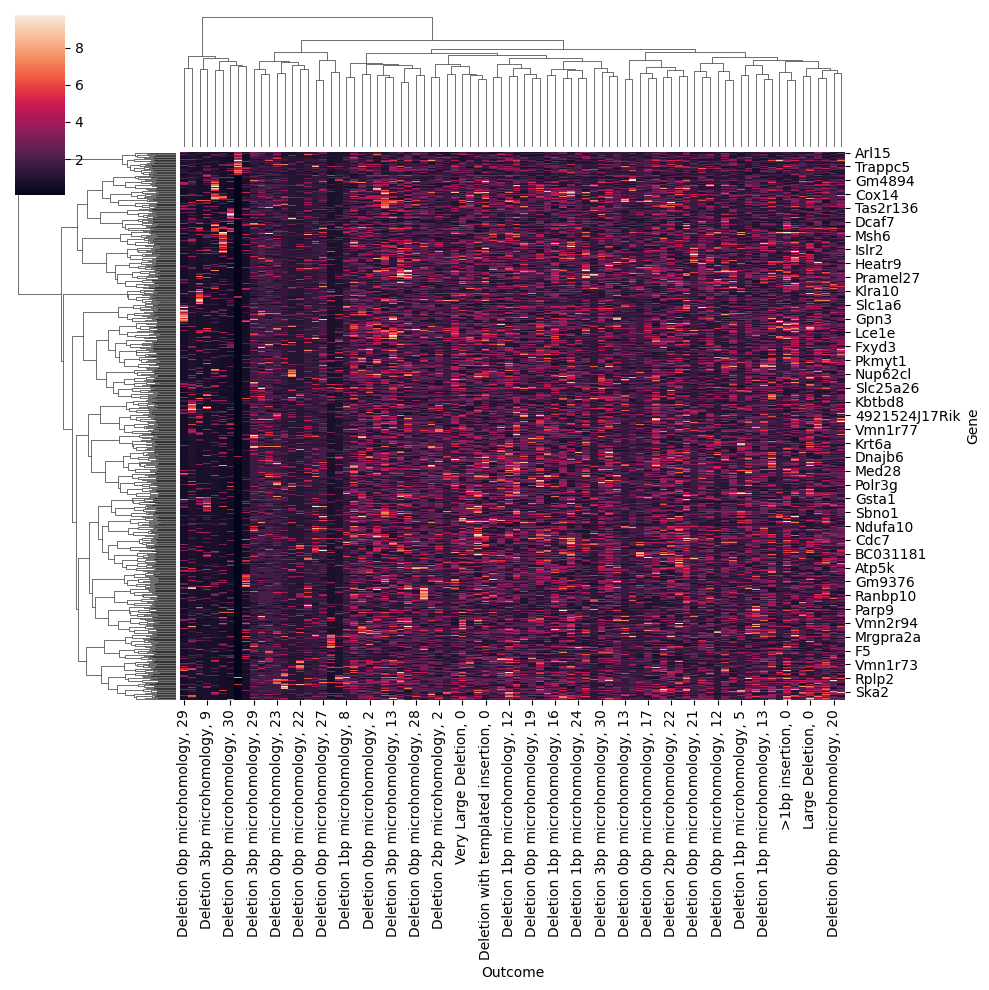

In [238]:
top1000 = mcd_scores_df.sort_values("total_score")[:1000]
top1000 = top1000[~top1000["T1"].isnull()].index
e = pd.DataFrame(ecod_output[0]["T1"].O, index=Ys[0]["T1"].index, columns=Ys[0]["T1"].columns)
e = e.loc[e.index.isin(top1000.to_list()),:]
e = e.drop("Deletion 2bp microhomology, 26", axis=1)
sns.clustermap(e, metric="correlation", method="ward")